# Introduction

### Covid-19 Lungs X-Rays Prediction using CNN for Binary Classification

COVID-19 tests are currently hard to come by — there are simply not enough of them and they cannot be manufactured fast enough, which is causing panic.

Given that there are limited COVID-19 testing kits, we need to rely on other diagnosis measures.

We thought to explore X-ray images as doctors frequently use X-rays and CT scans to diagnose pneumonia, lung inflammation, abscesses, and/or enlarged lymph nodes.

Since COVID-19 attacks the epithelial cells that line our respiratory tract, we can use X-rays to analyze the health of a patient’s lungs.

# Importing Libraries

In [3]:
!apt-get -qq install -y graphviz && pip install pydot


In [28]:
!pip install cartopy

     |████████████████████████████████| 10.8 MB 22.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 51.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 43.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 54.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 3.5 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516295 sha256=d70680c6a6093c88b83819a468cddf9ba9573ca6d932c0c4484abdc057c1b2a8
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy


In [29]:
!apt-get -qq install -y libfluidsynth1

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import cv2, os, gc, glob
from tqdm import tqdm

from tensorflow.keras import layers, models

import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [4]:
img = image.load_img("COVID-19 (1).png")

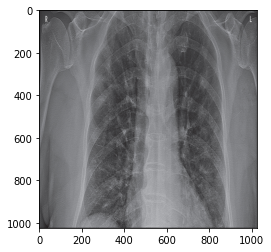

In [5]:
plt.imshow(img)

In [6]:
cv2.imread("COVID-19 (1).png").shape

(1024, 1024, 3)

# Splitting Data

In [7]:
pip install split-folders


In [8]:
import splitfolders
splitfolders.ratio('imgs', output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 1560 files [00:03, 403.36 files/s]


# Loading the Data

In [23]:
os.listdir('/content/imgs')

['COVID-19',
 '.ipynb_checkpoints',
 'NORMAL',
 'NORMAL.metadata.xlsx',
 'COVID-19.metadata.xlsx']

In [24]:
# Image paths

imagePaths = []
for dirname, _, filenames in os.walk('/content/imgs'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [33]:
# Data - Label

Data = []
Target = []
resize = 150

cat = {'NORMAL': 'Normal', 'COVID-19': 'Covid-19'}

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) /255

    Data.append(image)
    Target.append(cat[label])

100%|██████████| 1560/1560 [00:45<00:00, 34.05it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


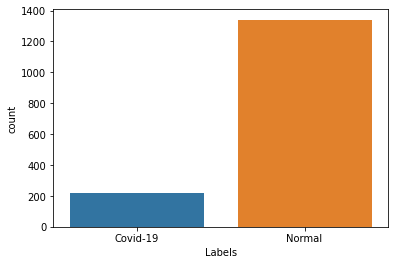

Covid-19: 219
Normal: 1341


In [34]:
# Count by Label

df = pd.DataFrame(Target,columns=['Labels'])
sns.countplot(df['Labels'])
plt.show()

print('Covid-19:',Target.count('Covid-19'))
print('Normal:',Target.count('Normal'))

In [35]:
# Images shape

size = []
for file in imagePaths: 
    image = plt.imread(file)
    size.append(image.shape)
pd.Series(size).value_counts()

(1024, 1024)       1349
(1024, 1024, 3)     211
dtype: int64

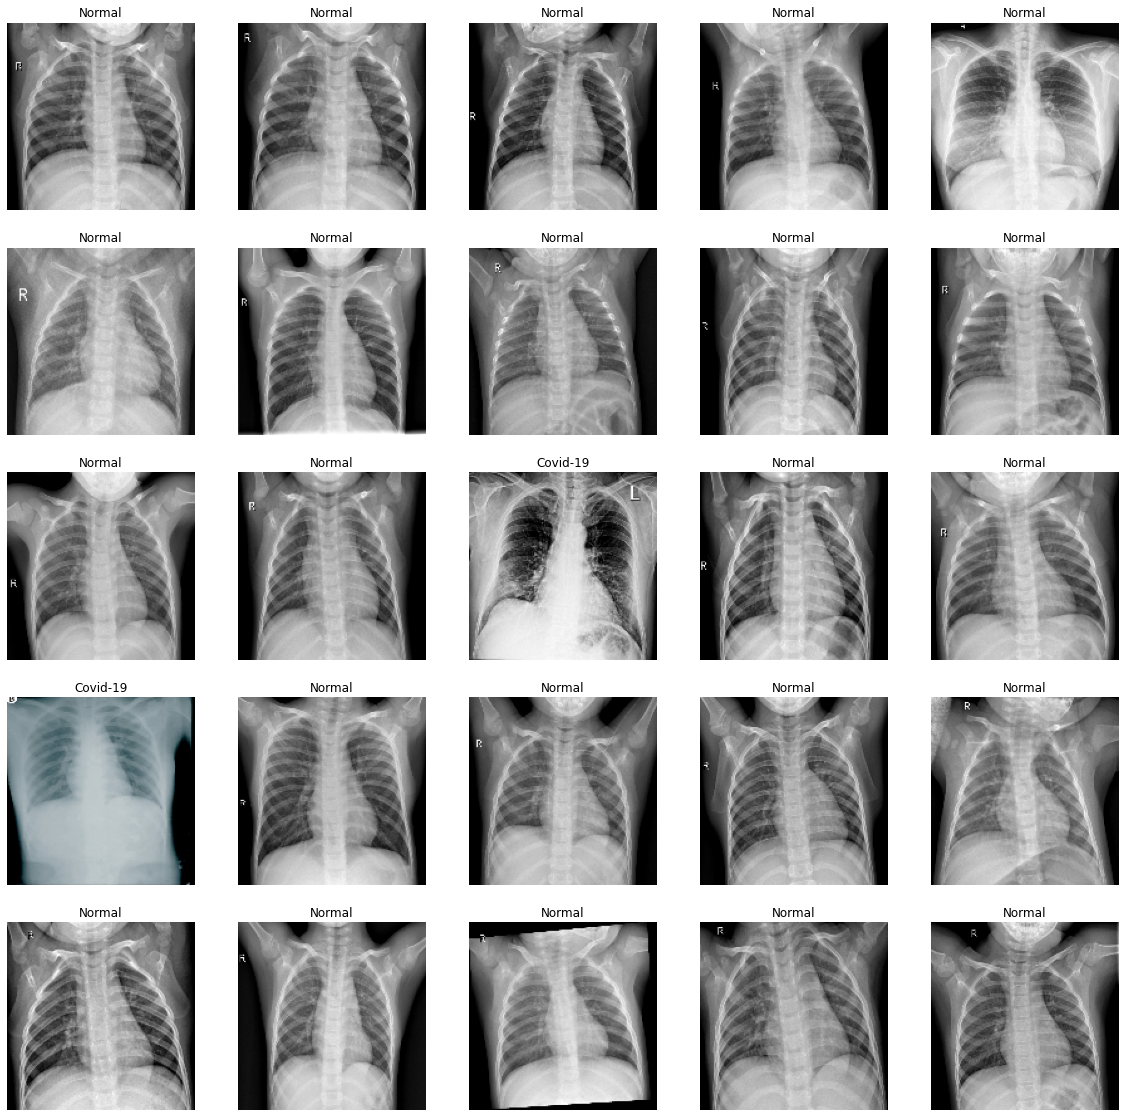

In [36]:
# Show Images

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(imagePaths),25))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(Data[i] , cmap='gray')
    plt.title(Target[i])
    plt.axis('off')     
plt.show()

# Preparing Data

In [37]:
# encode labels as integers

le = LabelEncoder()
labels = le.fit_transform(Target)
labels = to_categorical(labels)

print(le.classes_)
print(labels[0])

['Covid-19' 'Normal']
[1. 0.]


In [38]:
# split Data

(x_train, x_test, y_train, y_test) = train_test_split(Data, labels,test_size=0.20,
                                                      stratify=labels,random_state=42)

trainX = np.array(x_train)
testX = np.array(x_test)
trainY = np.array(y_train)
testY = np.array(y_test)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(1248, 150, 150, 3)
(312, 150, 150, 3)
(1248, 2)
(312, 2)


In [39]:
trainX[0]

array([[[0.21176471, 0.21176471, 0.21176471],
        [0.20784314, 0.20784314, 0.20784314],
        [0.19215686, 0.19215686, 0.19215686],
        ...,
        [0.41176471, 0.41176471, 0.41176471],
        [0.39607843, 0.39607843, 0.39607843],
        [0.38039216, 0.38039216, 0.38039216]],

       [[0.07843137, 0.07843137, 0.07843137],
        [0.07058824, 0.07058824, 0.07058824],
        [0.0627451 , 0.0627451 , 0.0627451 ],
        ...,
        [0.42745098, 0.42745098, 0.42745098],
        [0.38823529, 0.38823529, 0.38823529],
        [0.38431373, 0.38431373, 0.38431373]],

       [[0.0745098 , 0.0745098 , 0.0745098 ],
        [0.07843137, 0.07843137, 0.07843137],
        [0.06666667, 0.06666667, 0.06666667],
        ...,
        [0.39607843, 0.39607843, 0.39607843],
        [0.38823529, 0.38823529, 0.38823529],
        [0.41176471, 0.41176471, 0.41176471]],

       ...,

       [[0.07058824, 0.07058824, 0.07058824],
        [0.05490196, 0.05490196, 0.05490196],
        [0.05098039, 0

# Initiating the CNN

- Conv2D: is the 2D convolution layer that creates a covolution kernel that is convolved with the layer input to produce a tensor of outputs.
- MaxPool2D: is the method used for pooling the data.
- Flattening will consist of the result of all the previous convolution layers and the pooling into a one dimensional vector which will become the input of a future fully connected neural network.

In [75]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size =(3,3), activation = "relu", input_shape=(s,s,3), kernel_initializer='he_normal',))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2), strides = (1,1)))

model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation = "sigmoid"))

# Training the CNN

Optimizer:
- 'adam': this optimizer will perform Stochastic gradient descent (updating weights to reduce loss error between prediction & real results). Loss:
'binary_crossentropy': used for binary classification problems
- 'categorical_crossentropy': used for non-binary classification problems

In [76]:
# Compile 

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [77]:
# Model Details

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 33, 33, 128)     

epochs:

- number of times you want your neural network to run
- it will improve accuracy over time

In [78]:
epochs = 30

ThisModel = model.fit(trainX, trainY, epochs=epochs, batch_size=40, verbose=1)

Epoch 1/30
32/32 [==============================] - 58s 2s/step - loss: 0.4442 - accuracy: 0.8862
Epoch 2/30
32/32 [==============================] - 50s 2s/step - loss: 0.0990 - accuracy: 0.9728
Epoch 3/30
32/32 [==============================] - 50s 2s/step - loss: 0.0858 - accuracy: 0.9688
Epoch 4/30
32/32 [==============================] - 49s 2s/step - loss: 0.0626 - accuracy: 0.9832
Epoch 5/30
32/32 [==============================] - 49s 2s/step - loss: 0.0319 - accuracy: 0.9880
Epoch 6/30
32/32 [==============================] - 49s 2s/step - loss: 0.0456 - accuracy: 0.9880
Epoch 7/30
32/32 [==============================] - 50s 2s/step - loss: 0.0698 - accuracy: 0.9840
Epoch 8/30
32/32 [==============================] - 49s 2s/step - loss: 0.0324 - accuracy: 0.9904
Epoch 9/30
32/32 [==============================] - 50s 2s/step - loss: 0.0179 - accuracy: 0.9952
Epoch 10/30
32/32 [==============================] - 50s 2s/step - loss: 0.0104 - accuracy: 0.9992
Epoch 11/30
32/32 [

# Model Evaluation

In [79]:
modelLoss, modelAccuracy = model.evaluate(testX, testY, verbose=0)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))

Test Loss is 0.12289127707481384
Test Accuracy is 0.9871794581413269


In [80]:
class_names = ['COVID-19','Normal']

y_pred = model.predict(testX)
print(class_names[np.argmax(y_pred[1])])

Normal


In [81]:
# classification report on train
batch_size=40

predIdxs = model.predict (trainX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    1.00000   1.00000   1.00000       175
      Normal    1.00000   1.00000   1.00000      1073

    accuracy                        1.00000      1248
   macro avg    1.00000   1.00000   1.00000      1248
weighted avg    1.00000   1.00000   1.00000      1248



In [82]:
# classification report on test

predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.97619   0.93182   0.95349        44
      Normal    0.98889   0.99627   0.99257       268

    accuracy                        0.98718       312
   macro avg    0.98254   0.96404   0.97303       312
weighted avg    0.98710   0.98718   0.98705       312



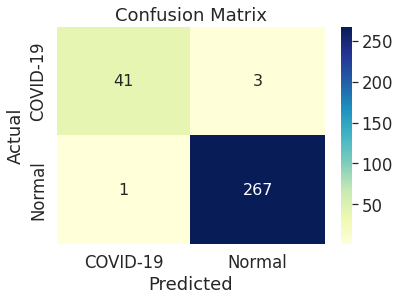

In [83]:
# Plotting Confusion Matrix
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x, index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

In [84]:
model.save('CNN_Covid19_Xray_V1.h5') 

# Conclusion

- Done Exploratory Image Data Analysis on Covid vs Normal Images using various techniques.
- Applied Convolutional Neural Network Model and got good Accuracy and Loss and prevented Overfitting.
- Applied Grad - CAM Analysis on Sample Images and found few insights.